<a href="https://colab.research.google.com/github/ritwiks9635/CNN_Project_File/blob/main/Vision_Transformer_for_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Vision Transformer**

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "username"
os.environ['KAGGLE_KEY'] = "kaggle_key"
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
#os path
api.dataset_download_files( "ashfakyeafi/glasses-classification-dataset",path="https://www.kaggle.com/datasets/ashfakyeafi/glasses-classification-dataset")
# unzip

In [ ]:
!unzip /content/https:/www.kaggle.com/datasets/ashfakyeafi/glasses-classification-dataset/glasses-classification-dataset.zip

In [ ]:
! pip install tensorflow --upgrade
! pip install keras --upgrade

In [4]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

In [5]:
train_data = keras.utils.image_dataset_from_directory(
    "/content/train",
    image_size = (64, 64),
    #batch_size = 64,
    shuffle = True,
    label_mode = "binary")

Found 104 files belonging to 2 classes.


In [6]:
val_data = keras.utils.image_dataset_from_directory(
    "/content/validate",
    image_size = (64, 64),
    #batch_size = 64,
    shuffle = True,
    label_mode = "binary")

Found 40 files belonging to 2 classes.


In [7]:
num_classes = 2
input_shape = (64, 64, 3)

In [44]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 256  # We'll resize input images to this size
patch_size = 18  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

In [33]:
x_train, y_train = next(iter(train_data))
x_train = x_train.numpy()
y_train = y_train.numpy()
x_val, y_val = next(iter(val_data))
x_val = x_val.numpy()
y_val = y_val.numpy()

In [34]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [35]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [45]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Image size: 256 X 256
Patch size: 18 X 18
Patches per image: 196
Elements per patch: 972


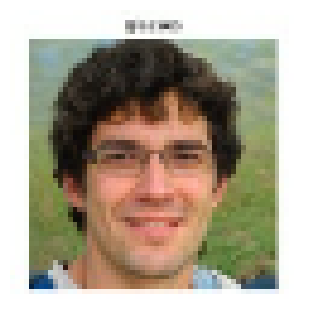

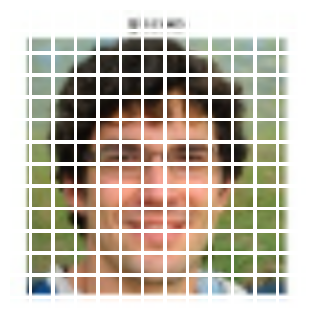

In [46]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

In [47]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [48]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5938 - loss: 1.1145 - top-5-accuracy: 1.0000 - val_accuracy: 0.7188 - val_loss: 1.1578 - val_top-5-accuracy: 1.0000
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7500 - loss: 2.0361 - top-5-accuracy: 1.0000 - val_accuracy: 0.5625 - val_loss: 15.5183 - val_top-5-accuracy: 1.0000
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5312 - loss: 8.8268 - top-5-accuracy: 1.0000 - val_accuracy: 0.4375 - val_loss: 21.8123 - val_top-5-accuracy: 1.0000
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5312 - loss: 13.3593 - top-5-accuracy: 1.0000 - val_accuracy: 0.6562 - val_loss: 4.7429 - val_top-5-accuracy: 1.0000
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7188 - loss: 2.5994 - top-5-accuracy: 1.0000 - val_accuracy: 0.5625 - val_loss: 5.9861 - val_top-5-accuracy: 1.0000
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6250 - loss: 2.2364 - top-5-accuracy: 1.0000 - val_

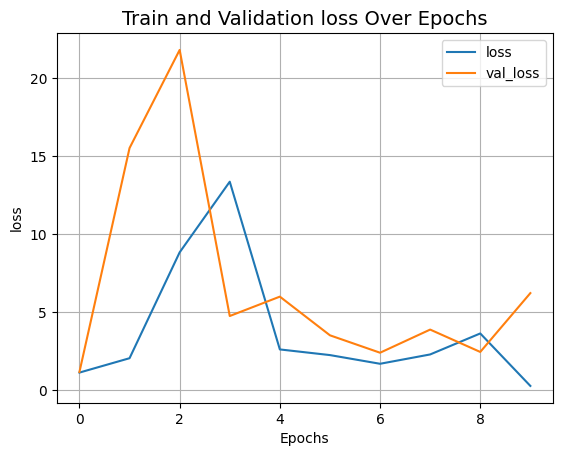

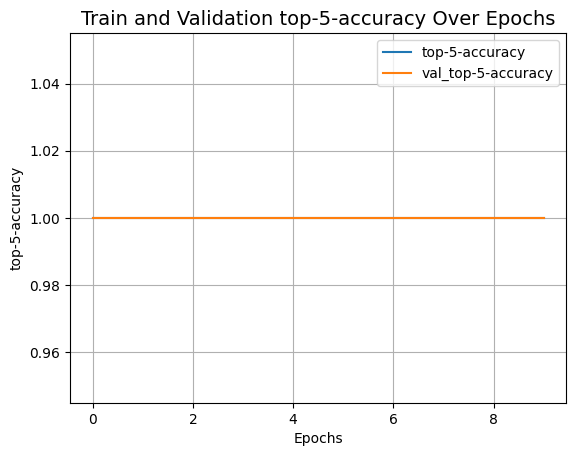

In [50]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data = (x_val, y_val),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_val, y_val)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")